# XGBoost

최적화된 그레디언트 부스팅 구현으로 XGBoost라는 것이 유명하다.

XGBoost는 eXtreme Gradient Boosting의 약자로서, 확장성 때문에 구조화된 데이터에 대한 응용 머신 러닝에서 많이 활용된다.

XGBoost는 gradient boost를 개선한 방법이라고 볼 수 있으며, 속도와 성능을 향상시키도록 특별히 설계되었다.

XGBoost에서 최적화를 위한 목적 함수의 두드러진 특징은 훈련 손실과 규제항의 두 부분으로 구성된다는 것이다.

Regularized learning을 통해 과적합을 피하고, 단순하고 예측가능한 모형을 선택할 수 있게 한다. 

$$ \text{obj}(\theta) = L(\theta) + \Omega(\theta) $$

Tree 방법에서 정규화항은 일종의 모델 복잡도 (complexity of the tree)로 정의된다.

그 외에 병렬화와 시스템 최적화로 기존의 gradient boosting에 비해 성능이 높다고 알려져 있다.

아래는 [XGBoost](https://xgboost.readthedocs.io/en/stable/tutorials/model.html) 패키지의 메뉴얼의 내용을 요약한 것이다.

### Tree

XGBoost는 CART(Classification And Regression Tree)들이 모인 일종의 앙상블 모형이다.

일반적인 gradient boosting과 동일한 방법으로부터 출발한다.

즉, boosting의 각 step에서 작은 트리 (weak learner)들을 적합한다.

학습된 트리는 이전 단계까지 학습된 모형에 합하는 additive 방식을 취한다.

XGBoost에서는 CART를 형성할 때 마지막 leaf 노드에서 일종의 숫자로 이루어진 score를 배정한다. 

예를 들어 A와 B 클래스가 있을 때, score는 높을수록 A 클래스에 속할 확률이 높고, score가 낮을수록 B 클래스에 속할 확률이 높아질 수 있도록 설계할 수 있을 것이다.

이 score는 일종의 모형 모수로서, 최적화의 대상이다.

### 규제항

XGBoost는 모델 복잡도를 낮추기 위해 규제항을 사용한다. 

어떤 트리 (weak learner) $f$에 대한 규제항은 다음과 같이 정의된다.

$$ \Omega(f) = \gamma T + \frac{1}{2} \lambda \sum_{j=1}^{T} w_j^2 $$

여기서 $T$는 $f$의 leaf node의 수이고, $w_j$는 각 leaf node의 score이다.

$\gamma$와 $\lambda$는 hyperparameter이다.

즉, leaf 노드의 숫자가 많을수록, 그리고 leaf node의 score들의 제곱이 클 수록 더 큰 페널티를 받는다.

### 2차 근사

XGBoost가 빠른 이유 중 하나는 최적화 단계에서 2차 근사를 사용하기 때문이다.

트리를 이용한 부스팅에서 step $t$까지 진행되었을 때 step $t$에서의 예측값은 다음으로 표현할 수 있다.

$$ \hat y^{(t)}_i = \sum_{k=1}^{t} f_k(x_i) = \hat y_{i}^{(t-1)} + f_t(x_i) $$

여기서 $f_t$는 step $t$에서 추가되는 트리이다.

XGBoost에서 어떤 loss function $\ell$에 대해 step $t$에서의 최적화의 대상이 되는 목적함수는 다음과 같이 표현된다.

$$ \mathrm{obj}^{(t)} = \sum_{i=1}^{n} \ell(y_i, \hat y_{i}^{(t)} ) + \Omega = \sum_{i=1}^{n} \ell(y_i,\hat y_{i}^{(t-1)} + f_t(x_i) ) + \Omega $$

Loss function의 두번째 인자에 대해 $\hat y_{i}^{(t-1)}$에서 Taylor 2차 근사를 하면
$$ \mathrm{obj}^{(t)} \approx  \sum_{i=1}^{n} \left[ \ell(y_i,\hat y_{i}^{(t-1)}) + g_i f_t(x_i) + \frac{1}{2} h_i f_t^2(x_i) \right]  + \Omega $$

로 표현할 수 있으며, 여기서 $g_i$와 $h_i$는 각각 $\ell(y_i, \hat y_{i}^{(t-1)})$의 두번째 인자에 대한 1차와 2차 미분을 $\hat y_{i}^{(t-1)}$에서 계산한 값이다:

$$ g_i = \left. \frac{\partial \ell(y_i, y)}{\partial y} \right|_{ y = \hat y_{i}^{(t-1)}} \quad  \left. h_i = \frac{\partial^2 \ell(y_i, y)}{\partial y^2} \right|_{ y = \hat y_{i}^{(t-1)}} $$

XGBoost 또한 일반적인 gradient boosting에서처럼 각 boosting step에서 새롭게 추가되는 트리 $f_t$에 대해서만 최적화를 진행하는 additive model이다.

* 모든 가능한 트리에 대해 최적화를 진행하는 것은 어렵기 때문

따라서 최적화를 step $t$에서만 추가되는 트리에 대해서만 진행한다면 목적함수에서 $\ell(y_i,\hat y_{i}^{(t-1)})$를 생략하고

$$ \mathrm{obj}^{(t)} \approx  \sum_{i=1}^{n} \left[ g_i f_t(x_i) + \frac{1}{2} h_i f_t^2(x_i) \right]  + \Omega $$

로 표현할 수 있다.

여기서 $g_i$와 $h_i$는 $t-1$ 단계까지의 계산된 값으로 산출되는 값들임을 살펴보라.

### Structure score

위 obj 함수는 규제항을 대입하여 다음과 같이 다시 표현할 수 있다.

$$ \mathrm{obj}^{(t)} \approx  \sum_{i=1}^{n} \left[ g_i f_t(x_i) + \frac{1}{2} h_i f_t^2(x_i) \right] +  \gamma T + \frac{1}{2} \lambda \sum_{j=1}^{T} w_j^2 $$

한편, 트리를 $f_t(x_i) = w_{q(x_i)}$로 표현할 수 있는데, 여기서 $q(x_i)$는 $x_i$를 해당 leaf의 index로 mapping하는 함수이다.

그러면,

$$ \mathrm{obj}^{(t)} \approx  \sum_{i=1}^{n} \left[ g_i w_{q(x_i)} + \frac{1}{2} h_i w^2_{q(x_i)} \right] +  \gamma T + \frac{1}{2} \lambda \sum_{j=1}^{T} w_j^2 $$

이며, 동일 leaf에서는 동일한 score를 가진다는 점을 이용하면,

$$ \mathrm{obj}^{(t)} \approx \sum_{j=1}^{T} \left[ \left(\sum_{i \in I_j} g_i \right)w_j + \frac{1}{2} \left(\sum_{i \in I_j} h_j + \lambda \right) w_j^2 \right] + \gamma T $$

이다.

$G_j = \sum_{i\in I_j} g_i $, $H_j = \sum_{i\in I_j} h_i $라고 하면,

$$ \mathrm{obj}^{(t)} \approx \sum_{j=1}^{T} \left[G_j w_j + \frac{1}{2} (H_j + \lambda) w_j^2 \right] + \gamma T $$

이며, $w_j$에 대한 이차식이다.

Leaf node의 스코어를 의미하는 $w_j$들은 서로 독립적이기 때문에, 각 $j$별로 optimal point를 구할 수 있으며, 이는

$$ w_j^* = -\frac{G_j}{H_j + \lambda} $$

이고, 이를 다시 obj 함수에 대입하면,

$$ \mathrm{obj}^* = - \frac{1}{2} \sum_{j=1}^{T} \frac{G_j^2}{ H_j + \lambda} + \gamma T $$

이다. 이를 tree structure score라고 부르자.

### 실제 학습 과정

각 부스팅 단계에서 최적의 트리를 찾아 보자.

이를 위해서는 위에서 설명한 tree structure score를 모든 가능한 트리마다 계산해 보아야 한다.

모든 가능한 weak learner들, 즉, 모든 가능한 feature variable들과 분할 기준에 대해 tree structure score를 계산해 본 후,

가장 작은 tree structure score를 가지는 트리를 선택하면 된다.

하지만 이는 계산상으로 쉽지 않아 일종의 greedy algorithm을 적용한다.

먼저 root로부터 트리의 가지를 한 번 분할하면서, 분할할 때 tree structure score를 최대한 작게 만드는 변수와 분할 지점을 찾는다.

이 때, 트리를 분할할 때 얻어지는 추가적인 score gain인

$$ \frac{1}{2} \left[ \frac{G_L^2}{H_L + \lambda} + \frac{G_R^2}{H_R + \lambda} - \frac{(G_L + G_R)^2}{H_L + H_R + \lambda} \right] - \gamma$$

를 고려한다. 

위 식은 트리를 추가적으로 분할할 때 가만히 두었을 때에 비해, score 상으로 이득을 얻는지 손해를 보는지 계산하며, 만약 이 값이 0보다 작으면 더이상 트리를 분할하지 않는다.

만약 트리가 분할된다면, 이 과정을 weak learner의 미리 설정해 놓은 max depth에 이르기까지 반복한다.

### 요약

1. 초기 모형 $f_0$은 손실 함수를 최소화하는 상수로 설정, 예를 들어 회귀 문제와 제곱손실함수의 경우 평균값 이용 <br><br>

2. $t = 1, \cdots, T$에 대해 다음을 반복 <br><br>

    1. root로부터 시작하여 tree structure score를 최소화하는 변수와 분할 지점 계산 <br><br>
    
    2. Weak learner $f_t$의 max depth에 도달하거나 score gain이 0보다 큰 동안 지속적으로 분할 시도 (tree structure score를 최소화하는 변수와 분할 지점을 계산) <br><br>
    
    3. Weak learner $f_t$ 훈련되면 이전까지 훈련된 모형에 $\eta$의 학습률로 합산 : $f = f_0 +\eta \sum_{j=1}^t f_j $, 

### [XGBoost](https://xgboost.readthedocs.io/en/stable/index.html) 

XGBoost를 구현한 라이브러리로서 python외에도 다양한 언어가 지원된다.

XGBoost 자체는 scikit-learn과는 별도의 라이브러리이지만, XGBoost는 scikit-learn의 인터페이스를 따르는 래퍼 클래스를 제공한다.

이를 통해, Scikit-learn의 일관된 API를 이용할 수 있다.

XGBoost의 scikit-learn 래퍼를 사용하려면 xgboost 패키지를 설치한 후, `xgboost.XGBRegressor` 또는 `xgboost.XGBClassifier`와 같은 클래스를 import하여 사용할 수 있다.

이러한 클래스는 scikit-learn의 `fit`, `predic`t 등과 같은 메서드를 제공하여 모델을 학습하고 예측할 수 있도록 한다.

#### 예제 : Iris 데이터

먼저 간단한 분류 모형을 연습해 보자.

기본적으로 XGBoost의 분류는 binary 분류를 기반으로 하기 때문에, 0과 1의 두 클래스가 있는 경우를 먼저 살펴본다.

Iris data의 y값은 3개의 클래스이나, 간단히 versicolor인지 아닌지 체크하는 문제를 살펴보자.

In [1]:
import xgboost
from xgboost import XGBClassifier

In [2]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
data = load_iris()
X_train, X_test, y_train, y_test = train_test_split(data['data'], data['target'], test_size=.2)

# versicolor or not
y_train[y_train != 1] = 0
y_test[y_test != 1] = 0
data.target_names

array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

연습을 위해 [`XGBClassifier`](https://xgboost.readthedocs.io/en/stable/python/python_api.html#xgboost.XGBClassifier)를 이용한 매우 간단한 모형을 살펴보자.

Weak learner는 최대 깊이 1의 stump이다.

Boosting의 단계 수는 2으로 하였다.

scikit-learn의 문법과 흡사하게, 분류기를 생성하고 `.fit` method를 이용해 훈련할 수 있다.

In [3]:
xg_clf = XGBClassifier(n_estimators=2, max_depth=1)

xg_clf 

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=1, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=2, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [4]:
xg_clf.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=1, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=2, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

비슷하게 `predict()`를 이용하여 클래스를 예측한다. 

In [5]:
xg_clf.predict(X_test)

array([0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0,
       1, 0, 1, 0, 1, 0, 0, 0])

In [6]:
y_test

array([0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0,
       1, 0, 1, 0, 1, 0, 0, 0])

[get_booster()](https://xgboost.readthedocs.io/en/stable/python/python_api.html#xgboost.XGBClassifier.get_booster)를 이용하면 훈련된 개별 트리들을 살펴볼 수 있다.

개별 트리들의 feature 변수 이름 또한 지정하였다.

각 트리를 그대로 출력하면, 인간이 알아볼 수 있는 형태는 아니다.

In [7]:
booster = xg_clf.get_booster()
booster.feature_names = list(data.feature_names)
individual_trees = list(booster)
individual_trees

위에서 생성한 부스터의 메쏘드인 [get_dump()](https://xgboost.readthedocs.io/en/stable/python/python_api.html#xgboost.Booster.get_dump)를 이용하면 트리들을 읽을 수 있는 문자열의 형태로 받아온다.

훈련된 간단한 stump들이 2개 있으며 분기 지점과 leaf node들의 score들을 관찰할 수 있다.

In [8]:
tree_list = booster.get_dump()

In [9]:
for i, tree in enumerate(tree_list):
    print(f"Tree {i}:\n{tree}\n")

Tree 0:
0:[petal length (cm)<2.45000005] yes=1,no=2,missing=1
	1:leaf=-0.548936188
	2:leaf=0.00740740774


Tree 1:
0:[petal width (cm)<1.75] yes=1,no=2,missing=1
	1:leaf=0.0231614411
	2:leaf=-0.538837016




혹은 다음의 방법으로 트리들을 관찰할 수 있다.

In [10]:
df_tree = booster.trees_to_dataframe()
df_tree

,Tree,Node,ID,Feature,Split,Yes,No,Missing,Gain,Cover,Category
0,0,0,0-0,petal length (cm),2.45,0-1,0-2,0-1,25.126965,30.000000,NaN
1,0,1,0-1,Leaf,NaN,NaN,NaN,NaN,-0.548936,10.750000,NaN
2,0,2,0-2,Leaf,NaN,NaN,NaN,NaN,0.007407,19.250000,NaN
3,1,0,1-0,petal width (cm),1.75,1-1,1-2,1-1,22.946129,29.228910,NaN
4,1,1,1-1,Leaf,NaN,NaN,NaN,NaN,0.023161,20.729027,NaN
5,1,2,1-2,Leaf,NaN,NaN,NaN,NaN,-0.538837,8.499884,NaN


각 weak learner들을 이용하여 예측을 할 수도 있다. `iteration_range`를 통해 예측에 사용할 트리들을 지정할 수 있다.

In [11]:
xg_clf.predict(X_test, iteration_range=(0, 1))

array([0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 0, 1, 1, 0, 1])

In [12]:
xg_clf.predict(X_test, iteration_range=(1, 2))

array([1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 1, 0, 1, 0])

In [13]:
xg_clf.predict(X_test)

array([0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0,
       1, 0, 1, 0, 1, 0, 0, 0])

다음의 과정을 통해 leaf score에 따라 분류가 어떻게 이루어지는지 대략적으로 파악할 수 있다.

먼저 [apply()](https://xgboost.readthedocs.io/en/stable/python/python_api.html#xgboost.XGBClassifier.apply)를 이용하여 테스트 데이터가 각 트리에서 어떤 leaf에 떨어지는지 살펴보자.

`apply()`는 X 값들을 인자로 받아, 각 값들이 어떤 leaf 노드로 떨어지는지 보여준다.

결과의 각 열이 각 트리를 나타내고, 각 열의 숫자값이 leaf의 index를 나타낸다.

In [14]:
import pandas as pd

df_X_test = pd.DataFrame(X_test, columns=data.feature_names)
applied = xg_clf.apply(df_X_test)
applied[:10, ]

array([[1., 1.],
       [2., 1.],
       [2., 1.],
       [2., 2.],
       [2., 1.],
       [1., 1.],
       [2., 1.],
       [2., 1.],
       [2., 2.],
       [2., 1.]], dtype=float32)

지금의 간단한 예제에서는 부스팅에 사용한 트리가 2개 밖에 없으므로, 다음의 간단한 코드를 통해 test 데이터가 어떤 스코어를 가지는지 계산해 볼 수 있다.

해당 스코어에 따라 어떤 클래스로 prediction이 이루어졌는지 살펴보자.

In [15]:
score_list = []
for i in range(0, X_test.shape[0]): #
    s1 = df_tree[df_tree["ID"] == "0-" + str(int(applied[i, 0]))]  # 첫번째 트리의 해당 노드에서 score 가져오기
    s2 = df_tree[df_tree["ID"] == "1-" + str(int(applied[i, 1]))]  # 두번째 트리의 해당 노드에서 score 가져오기
    score_list.append(s1.iloc[0, 8] + s2.iloc[0, 8])   # 각 트리의 leaf 노드 가중치들의 합

pd.DataFrame({"prediction": xg_clf.predict(X_test), "score": score_list})

,prediction,score
0,0,-0.525775
1,1,0.030569
2,1,0.030569
3,0,-0.531430
4,1,0.030569
5,0,-0.525775
6,1,0.030569
7,1,0.030569
8,0,-0.531430
9,1,0.030569


이번에는 Weak learner들의 max depth를 2로 늘리고, boosting 횟수를 3으로 늘렸다.

부스팅 단계에서 트리가 완전히 2번 분할되기도 하고 그렇지 않기도 함을 관찰할 수 있다.

In [16]:
xg_clf2 = XGBClassifier(n_estimators=3, max_depth=2)
xg_clf2.fit(X_train, y_train)
booster2 = xg_clf2.get_booster()
booster2.feature_names = list(data.feature_names)

tree_list2 = booster2.get_dump()
for i, tree in enumerate(tree_list2):
    print(f"Tree {i}:\n{tree}\n")

Tree 0:
0:[petal length (cm)<2.45000005] yes=1,no=2,missing=1
	1:leaf=-0.548936188
	2:[petal width (cm)<1.75] yes=3,no=4,missing=3
		3:leaf=0.446808517
		4:leaf=-0.536842108


Tree 1:
0:[petal length (cm)<2.45000005] yes=1,no=2,missing=1
	1:leaf=-0.430163115
	2:[petal length (cm)<4.75] yes=3,no=4,missing=3
		3:leaf=0.437782526
		4:leaf=-0.353588223


Tree 2:
0:[petal length (cm)<2.45000005] yes=1,no=2,missing=1
	1:leaf=-0.369415581
	2:[petal length (cm)<4.94999981] yes=3,no=4,missing=3
		3:leaf=0.334891111
		4:leaf=-0.342791647




In [17]:
df_tree2 = booster2.trees_to_dataframe()
df_tree2

,Tree,Node,ID,Feature,Split,Yes,No,Missing,Gain,Cover,Category
0,0,0,0-0,petal length (cm),2.45,0-1,0-2,0-1,25.126965,30.000000,NaN
1,0,1,0-1,Leaf,NaN,NaN,NaN,NaN,-0.548936,10.750000,NaN
2,0,2,0-2,petal width (cm),1.75,0-3,0-4,0-3,56.472538,19.250000,NaN
3,0,3,0-3,Leaf,NaN,NaN,NaN,NaN,0.446809,10.750000,NaN
4,0,4,0-4,Leaf,NaN,NaN,NaN,NaN,-0.536842,8.500000,NaN
5,1,0,1-0,petal length (cm),2.45,1-1,1-2,1-1,14.315624,28.125841,NaN
6,1,1,1-1,Leaf,NaN,NaN,NaN,NaN,-0.430163,9.979174,NaN
7,1,2,1-2,petal length (cm),4.75,1-3,1-4,1-3,34.713329,18.146667,NaN
8,1,3,1-3,Leaf,NaN,NaN,NaN,NaN,0.437783,8.089496,NaN
9,1,4,1-4,Leaf,NaN,NaN,NaN,NaN,-0.353588,10.057172,NaN


In [18]:
import pandas as pd
applied2 = xg_clf2.apply(df_X_test)
applied2

array([[1., 1., 1.],
       [3., 3., 3.],
       [3., 3., 3.],
       [4., 4., 4.],
       [3., 3., 3.],
       [1., 1., 1.],
       [3., 3., 3.],
       [3., 3., 3.],
       [4., 4., 4.],
       [3., 3., 3.],
       [4., 4., 3.],
       [1., 1., 1.],
       [1., 1., 1.],
       [3., 3., 3.],
       [4., 4., 3.],
       [3., 3., 3.],
       [4., 4., 4.],
       [4., 4., 3.],
       [4., 4., 4.],
       [4., 4., 4.],
       [4., 4., 4.],
       [1., 1., 1.],
       [3., 3., 3.],
       [4., 4., 4.],
       [3., 3., 3.],
       [1., 1., 1.],
       [3., 3., 3.],
       [4., 4., 4.],
       [1., 1., 1.],
       [4., 4., 4.]], dtype=float32)

이번에는 트리가 3개이기 때문에, `for`문 내에서 스코어를 3번 추출하여 계산한다. 

어떤 테스트 데이터에 대한 총 score는 각 트리의 leaf 노드에서 추출한 score들의 합이다.

마찬가지로 score에 따라 최종 prediction이 어떻게 이루어졌는지 관찰하자.

In [19]:
score_list2 = []
for i in range(0, X_test.shape[0]): #
    s1 = df_tree2[df_tree2["ID"] == "0-" + str(int(applied2[i, 0]))]
    s2 = df_tree2[df_tree2["ID"] == "1-" + str(int(applied2[i, 1]))]
    s3 = df_tree2[df_tree2["ID"] == "2-" + str(int(applied2[i, 2]))]

    score_list2.append(s1.iloc[0, 8] + s2.iloc[0, 8] + s3.iloc[0, 8])   # 각 트리의 leaf 노드 가중치들의 합

pd.DataFrame({"prediction": xg_clf2.predict(X_test), "score": score_list2})

,prediction,score
0,0,-1.348515
1,1,1.219482
2,1,1.219482
3,0,-1.233222
4,1,1.219482
5,0,-1.348515
6,1,1.219482
7,1,1.219482
8,0,-1.233222
9,1,1.219482


마지막으로 하이퍼파라미터들을 따로 셋팅하지 않고, xgboost를 진행해 본다.

xgboost의 파라미터 기본 셋팅은 다음 링크를 참조한다.

https://xgboost.readthedocs.io/en/stable/parameter.html

예를 들어, `max_depth`의 기본값은 6이다.

In [23]:
xg_clf_d = XGBClassifier()
xg_clf_d.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [24]:
pd.DataFrame({"prediction" : xg_clf_d.predict(X_test), "real _value" :y_test})

,prediction,real _value
0,0,0
1,1,0
2,1,1
3,0,0
4,1,1
5,0,0
6,1,1
7,1,1
8,0,0
9,1,1


In [28]:
#상당히 많은 트리들을 볼 수 있다.

boosters = xg_clf_d.get_booster()
boosters.feature_names = list(data.feature_names)

tree_list = boosters.get_dump()

len(tree_list)

100

In [29]:
print(tree_list[0])

0:[petal length (cm)<2.45000005] yes=1,no=2,missing=1
	1:leaf=-0.548936188
	2:[petal width (cm)<1.75] yes=3,no=4,missing=3
		3:[petal length (cm)<4.94999981] yes=5,no=6,missing=5
			5:leaf=0.541463435
			6:leaf=-0.120000005
		4:leaf=-0.536842108



In [27]:
print(tree_list[1])

0:[petal length (cm)<2.45000005] yes=1,no=2,missing=1
	1:leaf=-0.430163115
	2:[petal width (cm)<1.75] yes=3,no=4,missing=3
		3:[petal length (cm)<4.94999981] yes=5,no=6,missing=5
			5:leaf=0.425154209
			6:leaf=-0.0986384451
		4:leaf=-0.422059089



#### 예제 : `make_hastie_10_2` 

`make_hastie_10_2`를 이용하여 XGBoost와 일반 gradient boosting의 속도를 비교해 보자.

In [22]:
from sklearn import datasets

X, y = datasets.make_hastie_10_2(n_samples=12_000, random_state=1)

y[y == -1] = 0

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=2_000, shuffle=False
)


In [23]:
xgb_clf = XGBClassifier(n_estimators = 400, max_depth=1)

In [24]:
%%timeit
xgb_clf.fit(X_train, y_train)

314 ms ± 4.35 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [25]:
xgb_clf.score(X_test, y_test)

0.9485

In [26]:
from sklearn.ensemble import GradientBoostingClassifier
n_estimators = 400
gb_clf = GradientBoostingClassifier(n_estimators=n_estimators, max_depth=1)

In [27]:
%%timeit
gb_clf .fit(X_train, y_train)

4.42 s ± 27.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [28]:
gb_clf.score(X_test, y_test)

0.9005

### 하이퍼 파라미터

심장병 판별 자료 예제를 이용하여 XGBoost에서 하이퍼 파라미터를 어떻게 설정하는지 간단히 알아보자.

In [29]:
import pandas as pd
df = pd.read_csv("https://raw.githubusercontent.com/rickiepark/handson-gb/main/Chapter02/heart_disease.csv")
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    int64  
 13  target    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


In [31]:
from xgboost import XGBClassifier

In [32]:
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

`booster = "gbtree", objective = "binary:logistic"`는 사실 `XGBClassifier`의 default 값들이다.

In [33]:
model = XGBClassifier(booster = "gbtree", objective = "binary:logistic")

위 모델을 이용하여 5-fold cross validation 에러를 계산해 보자.

In [34]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(model, X, y, cv=5)
scores.mean()

0.8149726775956283

[`sklearn.model_selection.StratifiedKFold`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html)는 $y$의 클래스의 비율을 일정하게 하여 k-fold cross-validation을 하게 하므로, 더 정확한 테스트 에러 추정치를 얻을 수 있다.

In [35]:
from sklearn.model_selection import StratifiedKFold
kfold = StratifiedKFold(n_splits=5, shuffle=False)

In [36]:
scores = cross_val_score(model, X, y, cv=kfold)
scores.mean()

0.8149726775956283

하이퍼파라미터 튜닝은 기본적으로 [`sklearn.model_selection.GridSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) 나 [`sklearn.model_selection.RandomizedSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html)을 이용한다.

`sklearn.model_selection.GridSearchCV`는 하이퍼 파라미터들이 가질 수 있는 여러 값들을 지정하여 모두 테스트 하는 방식이다.

`param_grid`는 탐색할 파라미터 값들의 리스트를 나타내며, 파라미터 이름을 key로 삼아 dictionary로 표현된다.

비슷하게 `sklearn.model_selection.RandomizedSearchCV`는 탐색할 파라미터가 램덤하게 샘플링될 분포를 `param_distributions`로 제공해 주어야 한다.

In [37]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

많은 하이퍼 파라미터들에 대해 비슷한 작업을 수행할 것이므로, 함수로 만들어 사용해 보자.

`random`이 `False`일 경우 grid search를 `True`일 경우 Randomized search를 한다.

In [51]:
def grid_search(params, random=False): 

    xgb = XGBClassifier(booster='gbtree', objective='binary:logistic', verbosity=0)
    
    kfold = StratifiedKFold(n_splits=5, shuffle=True)
    
    if random:
        grid = RandomizedSearchCV(estimator = xgb, param_distributions = params, cv=kfold, n_iter=20, 
                                  n_jobs=-1)
    else:
        grid = GridSearchCV(estimator = xgb, param_grid = params, cv=kfold, n_jobs=-1)
    
    grid.fit(X, y)

    best_params = grid.best_params_
    print("최상의 매개변수:", best_params) 
    best_score = grid.best_score_
    print("최상의 점수: {:.5f}".format(best_score))
    
    return grid

In [52]:
_ = grid_search(params={'n_estimators':[100, 200, 400, 800]})

최상의 매개변수: {'n_estimators': 800}
최상의 점수: 0.79514


In [53]:
_ = grid_search(params={'learning_rate':[0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]})

최상의 매개변수: {'learning_rate': 0.01}
최상의 점수: 0.81497


In [54]:
_ = grid_search(params={'max_depth':[2, 3, 5, 6, 8]})

최상의 매개변수: {'max_depth': 6}
최상의 점수: 0.80530


In [55]:
_ = grid_search(params={'gamma':[0, 0.01, 0.1, 0.5, 1, 2]})

최상의 매개변수: {'gamma': 0.5}
최상의 점수: 0.81852


In [56]:
_ = grid_search(params={'min_child_weight':[1, 2, 3, 4, 5]})

최상의 매개변수: {'min_child_weight': 5}
최상의 점수: 0.82508


In [57]:
_ = grid_search(params={'subsample':[0.5, 0.7, 0.8, 0.9, 1]})

최상의 매개변수: {'subsample': 0.8}
최상의 점수: 0.80536


In [58]:
_ = grid_search(params={'colsample_bytree':[0.5, 0.7, 0.8, 0.9, 1]})

최상의 매개변수: {'colsample_bytree': 0.7}
최상의 점수: 0.81525


탐색의 대상이 너무 많을 때는 randomized search를 사용하는 것도 좋은 방법이다.

다음의 parameter 조합은 너무 많기 때문에, random search를 이용했다.

In [59]:
grid = grid_search(params={'subsample':[0.5, 0.6, 0.7, 0.8, 0.9, 1], 
                    'min_child_weight':[1, 2, 3, 4, 5], 
                    'learning_rate':[0.1, 0.2, 0.3, 0.4, 0.5], 
                    'max_depth':[1, 2, 3, 4, 5, None], 
                    'n_estimators':[2, 25, 50, 75, 100]}, random=True)

최상의 매개변수: {'subsample': 1, 'n_estimators': 25, 'min_child_weight': 5, 'max_depth': 1, 'learning_rate': 0.3}
최상의 점수: 0.84792


In [60]:
grid.best_params_

{'subsample': 1,
 'n_estimators': 25,
 'min_child_weight': 5,
 'max_depth': 1,
 'learning_rate': 0.3}

In [63]:
xgb_op = grid.best_estimator_

In [64]:
xgb_op.fit(X, y)

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.3, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=1, max_leaves=None,
              min_child_weight=5, missing=nan, monotone_constraints=None,
              n_estimators=25, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [65]:
xgb_op.feature_importances_

array([0.02731032, 0.0410008 , 0.20945054, 0.        , 0.0220396 ,
       0.        , 0.        , 0.03654748, 0.07166743, 0.0940531 ,
       0.1382484 , 0.16266246, 0.19701989], dtype=float32)

In [68]:
for feat, importance in zip(X.columns, xgb_op.feature_importances_):
    print('feature: {f}, importance: {i}'.format(f=feat, i=importance))

feature: age, importance: 0.027310319244861603
feature: sex, importance: 0.04100079834461212
feature: cp, importance: 0.20945054292678833
feature: trestbps, importance: 0.0
feature: chol, importance: 0.02203960344195366
feature: fbs, importance: 0.0
feature: restecg, importance: 0.0
feature: thalach, importance: 0.036547478288412094
feature: exang, importance: 0.07166743278503418
feature: oldpeak, importance: 0.09405309706926346
feature: slope, importance: 0.13824839890003204
feature: ca, importance: 0.16266246140003204
feature: thal, importance: 0.19701988995075226


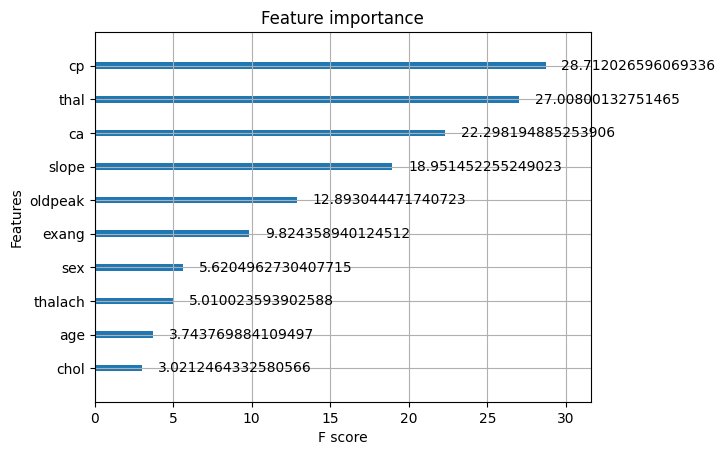

In [72]:
from xgboost import plot_importance
_ = plot_importance(xgb_op, importance_type='gain')